<a href="https://colab.research.google.com/github/voshna123/tensorflow_practice/blob/main/foodrecog_big_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-01-10 02:22:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-10 02:22:14 (97.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves,compare_historys

## Loading 101Food Dataset

In [3]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2025-01-10 02:22:22--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2025-01-10 02:22:23--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  18.6MB/s    in 4m 9s   

2025-01-10 02:26:32 (19.2 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [4]:
# importing the "tarfile" module
import tarfile

# open file
file = tarfile.open('/content/food-101.tar.gz')

# extracting file
file.extractall()

file.close()

## plot the img

In [5]:
import os
import shutil
import random
from pathlib import Path
from typing import Dict

def split_nested_folders(
    source_folder: str,
    train_folder: str,
    test_folder: str,
    split_ratio: float = 0.8,
    random_seed: int = 42
) -> Dict[str, Dict[str, int]]:
    """
    Split a nested folder structure into training and test sets while preserving hierarchy.

    Args:
        source_folder: Path to the root folder containing nested folders
        train_folder: Path where training files will be copied
        test_folder: Path where test files will be copied
        split_ratio: Proportion of files to use for training (default: 0.8)
        random_seed: Random seed for reproducibility (default: 42)

    Returns:
        Dict containing statistics for each subfolder
    """
    random.seed(random_seed)

    # Convert to Path objects
    source_path = Path(source_folder)
    train_path = Path(train_folder)
    test_path = Path(test_folder)

    # Create output root directories
    train_path.mkdir(parents=True, exist_ok=True)
    test_path.mkdir(parents=True, exist_ok=True)

    stats = {}

    # Walk through all subdirectories
    for root, dirs, files in os.walk(source_path):
        if not files:
            continue

        # Get the relative path from source root
        rel_path = Path(root).relative_to(source_path)

        # Create corresponding directories in train and test
        train_subdir = train_path / rel_path
        test_subdir = test_path / rel_path

        train_subdir.mkdir(parents=True, exist_ok=True)
        test_subdir.mkdir(parents=True, exist_ok=True)

        # Shuffle files
        random.shuffle(files)

        # Calculate split point
        split_idx = int(len(files) * split_ratio)
        train_files = files[:split_idx]
        test_files = files[split_idx:]

        # Copy files to respective directories
        for file in train_files:
            src_file = Path(root) / file
            dst_file = train_subdir / file
            shutil.copy2(src_file, dst_file)

        for file in test_files:
            src_file = Path(root) / file
            dst_file = test_subdir / file
            shutil.copy2(src_file, dst_file)

        # Store statistics
        stats[str(rel_path)] = {
            'train': len(train_files),
            'test': len(test_files),
            'total': len(files)
        }

    # Calculate total statistics
    total_stats = {
        'train': sum(s['train'] for s in stats.values()),
        'test': sum(s['test'] for s in stats.values()),
        'total': sum(s['total'] for s in stats.values())
    }
    stats['total'] = total_stats

    return stats

In [6]:
stats = split_nested_folders("food-101/images",
                                     "train",
                                     "test")

In [7]:
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/train",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle = True,
    seed = 42
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/test",
    label_mode="categorical",
    image_size=(224, 224),
    batch_size=32,
    shuffle = False,
    seed = 42
)


Found 80800 files belonging to 101 classes.
Found 20200 files belonging to 101 classes.


## Preprocessing data

In [8]:
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [9]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>)

## Creating chck callback

In [10]:
chck_path ="chck.weights.h5"

chck = tf.keras.callbacks.ModelCheckpoint(chck_path,
                                          monitor = 'val_accuracy',
                                          save_best_only = True,
                                          save_weights_only = True)

## setup mixed precision

In [11]:
## this must be run on at least T4 GPU
tf.keras.mixed_precision.set_global_policy('mixed_float16')

## build model

In [12]:
base = tf.keras.applications.EfficientNetB0(include_top = False)
base.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [13]:
Inputs = tf.keras.layers.Input(shape = (224,224,3),name = "input_layer")
x = base(Inputs,training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(101,activation = "softmax", dtype = tf.float32)(x)

model = tf.keras.Model(Inputs,outputs)

In [14]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [15]:
for x in model.layers:
  print(x.name, x.dtype, x.trainable, x.dtype_policy)

input_layer float32 True <DTypePolicy "mixed_float16">
efficientnetb0 float32 False <DTypePolicy "mixed_float16">
global_average_pooling2d float32 True <DTypePolicy "mixed_float16">
dense float32 True <DTypePolicy "float32">


In [16]:
for x in model.layers[1].layers:
  print(x.name, x.dtype, x.trainable, x.dtype_policy)

input_layer float32 False <DTypePolicy "mixed_float16">
rescaling float32 False <DTypePolicy "mixed_float16">
normalization float32 False <DTypePolicy "mixed_float16">
rescaling_1 float32 False <DTypePolicy "mixed_float16">
stem_conv_pad float32 False <DTypePolicy "mixed_float16">
stem_conv float32 False <DTypePolicy "mixed_float16">
stem_bn float32 False <DTypePolicy "mixed_float16">
stem_activation float32 False <DTypePolicy "mixed_float16">
block1a_dwconv float32 False <DTypePolicy "mixed_float16">
block1a_bn float32 False <DTypePolicy "mixed_float16">
block1a_activation float32 False <DTypePolicy "mixed_float16">
block1a_se_squeeze float32 False <DTypePolicy "mixed_float16">
block1a_se_reshape float32 False <DTypePolicy "mixed_float16">
block1a_se_reduce float32 False <DTypePolicy "mixed_float16">
block1a_se_expand float32 False <DTypePolicy "mixed_float16">
block1a_se_excite float32 False <DTypePolicy "mixed_float16">
block1a_project_conv float32 False <DTypePolicy "mixed_float16"

In [18]:
hist = model.fit(train_data,
          epochs = 3,
          validation_data = test_data,
          validation_steps = int(0.15 * len(test_data)),
          callbacks = [chck,create_tensorboard_callback("exp", "3_ep_base")])

Saving TensorBoard log files to: exp/3_ep_base/20250110-023037
Epoch 1/3
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 213s 84ms/step - accuracy: 0.5687 - loss: 1.7767 - val_accuracy: 0.5947 - val_loss: 1.5683
Epoch 2/3
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 201s 80ms/step - accuracy: 0.6507 - loss: 1.3392 - val_accuracy: 0.6080 - val_loss: 1.5110
Epoch 3/3
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 178s 70ms/step - accuracy: 0.6855 - loss: 1.2042 - val_accuracy: 0.6912 - val_loss: 1.2151


In [19]:
model.evaluate(test_data)

632/632 ━━━━━━━━━━━━━━━━━━━━ 55s 87ms/step - accuracy: 0.6395 - loss: 1.3914


[1.3138246536254883, 0.659900963306427]

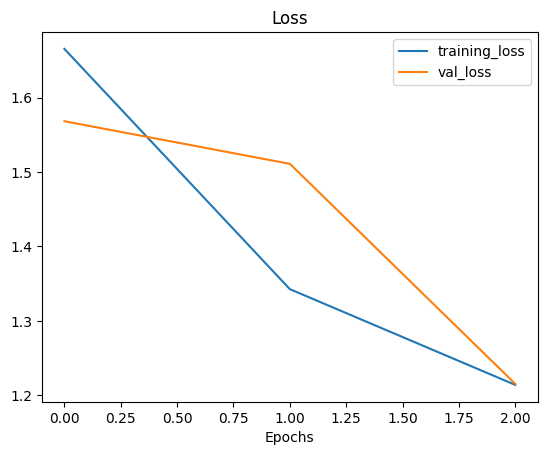

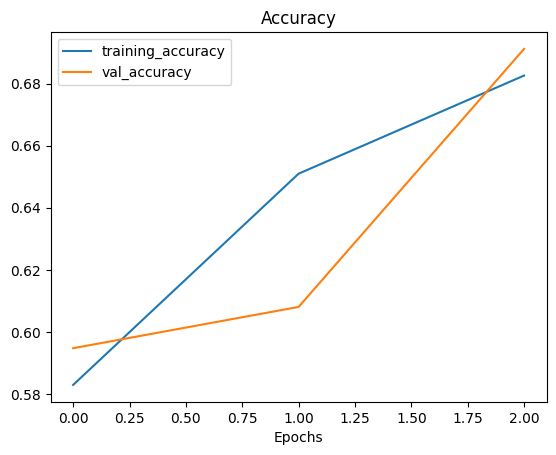

In [20]:
plot_loss_curves(hist)

## with fine tuning

In [21]:
for layer in base.layers[-10:]:
  layer.trainable = True

In [22]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ["accuracy"])

In [23]:
for layer in model.layers[1].layers:
  print(layer, layer.trainable)

<InputLayer name=input_layer, built=True> False
<Rescaling name=rescaling, built=True> False
<Normalization name=normalization, built=True> False
<Rescaling name=rescaling_1, built=True> False
<ZeroPadding2D name=stem_conv_pad, built=True> False
<Conv2D name=stem_conv, built=True> False
<BatchNormalization name=stem_bn, built=True> False
<Activation name=stem_activation, built=True> False
<DepthwiseConv2D name=block1a_dwconv, built=True> False
<BatchNormalization name=block1a_bn, built=True> False
<Activation name=block1a_activation, built=True> False
<GlobalAveragePooling2D name=block1a_se_squeeze, built=True> False
<Reshape name=block1a_se_reshape, built=True> False
<Conv2D name=block1a_se_reduce, built=True> False
<Conv2D name=block1a_se_expand, built=True> False
<Multiply name=block1a_se_excite, built=True> False
<Conv2D name=block1a_project_conv, built=True> False
<BatchNormalization name=block1a_project_bn, built=True> False
<Conv2D name=block2a_expand_conv, built=True> False
<Ba

In [24]:
hist_2 = model.fit(train_data,
          epochs = 6,
          validation_data = test_data,
          validation_steps = int(0.15 * len(test_data)),
          callbacks = [create_tensorboard_callback("exp", "3_ep_base_fine_tune")],
          initial_epoch=3)

Saving TensorBoard log files to: exp/3_ep_base_fine_tune/20250110-024214
Epoch 4/6
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 231s 81ms/step - accuracy: 0.6978 - loss: 1.1528 - val_accuracy: 0.6636 - val_loss: 1.3053
Epoch 5/6
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 226s 72ms/step - accuracy: 0.7459 - loss: 0.9635 - val_accuracy: 0.6822 - val_loss: 1.2458
Epoch 6/6
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 177s 70ms/step - accuracy: 0.7680 - loss: 0.8733 - val_accuracy: 0.7271 - val_loss: 1.0582


In [25]:
model.evaluate(test_data)

632/632 ━━━━━━━━━━━━━━━━━━━━ 50s 79ms/step - accuracy: 0.6880 - loss: 1.1922


[1.1436885595321655, 0.7023762464523315]

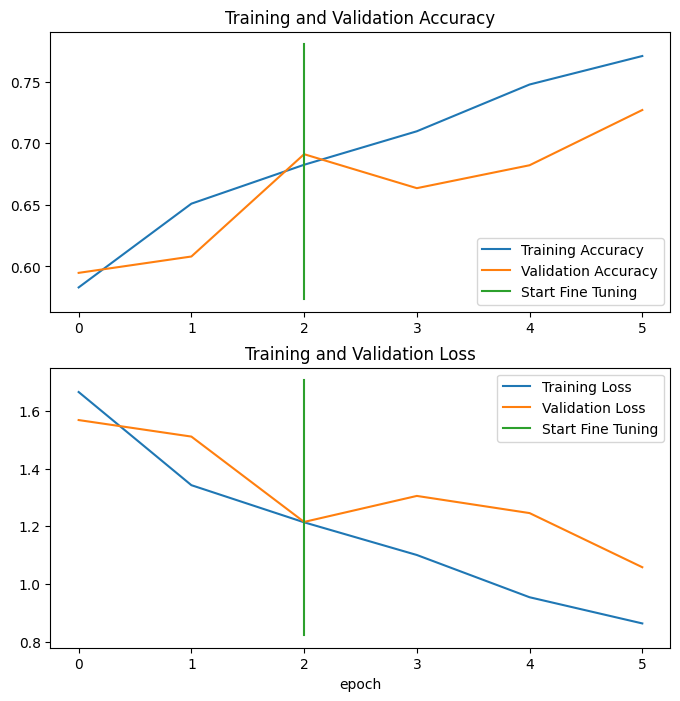

In [27]:
compare_historys(hist, hist_2,3)

## with data augment

In [28]:
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
])

In [29]:
base = tf.keras.applications.EfficientNetB0(include_top = False)
base.trainable = False

In [30]:
Inputs = tf.keras.layers.Input(shape = (224,224,3),name = "input_layer")
x = data_augment(Inputs)
x = base(x,training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(101,activation = "softmax", dtype = tf.float32)(x)

model_1 = tf.keras.Model(Inputs,outputs)

In [31]:
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [32]:
chck_2_path ="chck_data_aug.weights.h5"

chck_2 = tf.keras.callbacks.ModelCheckpoint(chck_2_path,
                                          monitor = 'val_accuracy',
                                          save_best_only = True,
                                          save_weights_only = True)

In [ ]:
hist_3 = model_1.fit(train_data,
          epochs = 3,
          validation_data = test_data,
          validation_steps = int(0.15 * len(test_data)),
          callbacks = [chck_2,create_tensorboard_callback("exp", "3_ep_data_aug")])

Saving TensorBoard log files to: exp/3_ep_data_aug/20250110-025457
Epoch 1/3
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 227s 84ms/step - accuracy: 0.3677 - loss: 2.7551 - val_accuracy: 0.5678 - val_loss: 1.6993
Epoch 2/3
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 246s 80ms/step - accuracy: 0.5333 - loss: 1.8348 - val_accuracy: 0.5605 - val_loss: 1.7204
Epoch 3/3
 813/2525 ━━━━━━━━━━━━━━━━━━━━ 2:06 74ms/step - accuracy: 0.5663 - loss: 1.6840

In [ ]:
model_1.evaluate(test_data)

In [ ]:
plot_loss_curves(hist_3)

## data aug fine tune

In [ ]:
for layer in base.layers[-10:]:
  layer.trainable = True

In [ ]:
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ["accuracy"])

In [ ]:
for layer in model.layers[1].layers:
  print(layer, layer.trainable)

In [ ]:
hist_4 = model_1.fit(train_data,
          epochs = 6,
          validation_data = test_data,
          validation_steps = int(0.15 * len(test_data)),
          callbacks = [create_tensorboard_callback("exp", "3_ep_data_aug_fine_tune")],
          initial_epoch=3)

In [ ]:
model_1.evaluate(test_data)

In [ ]:
compare_historys(hist_3, hist_4)